# NYISO Hourly Load Forecast
In this project, I provide the test of several models in forecasting hourly electricity load in New York City. Using data from the New York Independent System Operator (NYISO) and the National Oceanic and Atmospheric Administration, I apply several time series analysis techniques and provide forecasting model frameworks and their results.

### Business Understanding
Independent System Operators are entities that coordinate the electric grid in order to provide a well-functioning system with reliability. One can imagine the significant social and economic costs of such systems malfunction. As a whole, the system involves the participation of generators, transmission and utility companies - and the general public.

The proper operation of the system is a complete task, that has several steps. Focusing on one of its several activities, I provide a simplified study using forecasting tools in order to check whether they are reliable methodologies to forecast the system's load. Suppose - once again over a simplified scenario - that forecasting problems could lead to black-outs. 

The estimate cost of a blackout in New York City alone is around <a href = 'https://www.cnn.com/2019/07/14/us/new-york-city-power-outage-42-years-trnd/index.html' alt = 'CNN - New York City Power Outage'>$350 million</a>.  Even though forecasting per se isn't the reason for black-outs (most of the time), it can set some bounds to the cost of a system malfunction. The business problem can be stated as diminishing the risk of load mismatching aiming for an operation without hiccups.

The stakeholders of this problem are the general public: generators, transmission and utilities from the New York City Area.

## Basic Libraries and Functions
I start by importing the libraries that are going to be used. After that, I build a set of functions that will execute tasks on the DataFrames that are going to be analyzed. The aim of these functions is to streamline the procedures that are going to be performed on the dataset.

In [2]:
import os
import keras
import shutil
import requests
import numpy as np
import pandas as pd
# import logging
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from prophet import Prophet
import statsmodels.api as sm
from bs4 import BeautifulSoup
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [3]:
# Defining the support functions 

def file_fetch(url, target_folder, year_start):

    '''This function have as inputs an url, the name of the target folder that all the files will be stored and the year_start. All inputs are strings.'''
    
    # URL to be fetched from 
    url_fetch = url
    response = requests.get(url)

    # Parsing the HTML content
    soup = BeautifulSoup(response.content, 'html.parser')

    # Finding the section with the 'Archived Files (zip format)' title
    section = soup.find('th', string = 'Archived Files (zip format)')

    # Selecting the parent table and rows within it
    parent_table = section.find_parent('table')
    rows = parent_table.find_all('tr')

    # Initializing a list to store the file URLs
    file_urls = []

    # Iterating through the rows to find the CSV file URLs
    for row in rows:
        # Getting the cells in each row
        cells = row.find_all('td')

        # Checking if the cells contain the CSV file URLs
        if cells and cells[0].find('a') and cells[0].find('a').get('href').endswith('.zip'):
            year = cells[0].find('a').text[-4:]
            if int(year) >= int(year_start):
                file_url = url.rsplit('/', 1)[0] + '/' + cells[0].find('a').get('href')
                file_urls.append(file_url)

    # Creating the target folder if it doesn't exist
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    # Downloading the files to the target folder
    for file_url in file_urls:
        file_name = file_url.split('/')[-1]
        file_path = os.path.join(target_folder, file_name)
        if not os.path.exists(file_path):
            print(f'Downloading {file_name}...')
            with open(file_path, 'wb') as f:
                response = requests.get(file_url)
                f.write(response.content)
        else:
            print(f'{file_name} already exists, skipping...')

def file_mgmt(main_folder):

    '''This function will inspect the folder (passed as input) and will move the files to its outer level.'''

    # Iterate through all subfolders in main folder
    for subfolder in os.listdir(main_folder):
        subfolder_path = os.path.join(main_folder, subfolder)
        
        # Check if subfolder is a directory
        if os.path.isdir(subfolder_path):
            
            # Iterate through all files in subfolder
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                # Move file to main folder
                shutil.move(file_path, main_folder)
            
def merge_csv(folder_path):
    
    '''Merge multiple CSV files in a given folder into a single Dataframe.'''
    
    # Get all files in the folder
    files = os.listdir(folder_path) 

    # Filter for only CSV files
    csv_files = [f for f in files if f.endswith('.csv')] 
    csv_files = sorted(csv_files)
    dfs = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file) 
        df = pd.read_csv(file_path) 
        dfs.append(df)
    merged_df = pd.concat(dfs, ignore_index=True)
    return merged_df

def mape(y_true, y_hat):

    '''This function calculates the Mean Absolute Percentage Error and takes as input the true Y values (y_true) and the predicted Y
    values (y_hat)'''

    return np.mean(np.abs((y_true - y_hat) / y_true)) * 100

def mean_absolute_percent_error(y_true, y_pred):
    '''This function calculates the Mean Absolute Percentage Error and takes as input the true Y values (y_true) and the predicted Y
    values (y_hat) - however, to be used with keras'''
    
    return K.mean(K.abs((y_true - y_pred) / y_true)) * 100


# Defining a function for ACF and PACF plots - inspired by Flatiron School's Time Series Lab
def func_plot(dataframe):
    
    '''This function will plot the autocorrelation and partial autocorrelation plots from a DataFrame.'''
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,8))
    plot_acf(dataframe, ax = ax1, lags = 120)
    plot_pacf(dataframe, ax = ax2, lags = 120)
    plt.show();


def mape_calc(df, exog = None, pdq = (0,0,0), pdqs = (0,0,0,0), train_test = 'train', window = 24):
    
    '''This function calculates the Mean Absolute Percent Error for train (default) or \
    testing data, taking as input the dataframe, the pdq and pdqs factors (order and seasonal order) \
    an argument (i.e whether 'test' or 'train') and a default window of 24 periods. Its outputs are \
    the summary diagnostic for the SARIMAX model, with plots and the MAPE.
    '''
    
    # If 'train' or else
    if train_test == 'train':
        train = df['Load'].dropna()
        exog_var = exog.reindex(train.index)
        model = SARIMAX(train, order = pdq, seasonal_order = pdqs, exog = exog_var)
        output = model.fit()
        y_hat = output.predict(-window)
        mse = mape(train[-window:], y_hat)
        print(output.summary())
        output.plot_diagnostics(figsize=(10,5))
       
    else:
        test = df['Load'].dropna()
        exog_var = exog.reindex(test.index)
        model = SARIMAX(test, order = pdq, seasonal_order = pdqs, exog = exog_var)
        output = model.fit()
        y_hat = output.predict(-window)
        mse = mape(test[-window:], y_hat)
        print(output.summary())
        output.plot_diagnostics(figsize = (10,5))
        
    print(f'MAPE: {mse}')




def forecast_ci(df, exog=None, pdq=(0,0,0), pdqs=(0,0,0,0)):
    '''This function takes as input a dataframe, exogenous variables, and the order and seasonal order factors
    and retrieves the mean predicted values for a horizon with confidence intervals around 0.1-0.9.
    It also calculates the Mean Absolute Percent Error (MAPE) between the predicted and actual values.
    '''
    df = df.reset_index().set_index('Time Stamp')
    if exog is not None:
        exog = exog.reset_index().set_index('Time Stamp')
        model = SARIMAX(df, exog=exog, order=pdq, seasonal_order=pdqs)
    else:
        model = SARIMAX(df, order=pdq, seasonal_order=pdqs)

    output = model.fit()

    if exog is not None:
        pred = output.get_prediction(start = df.index[0], end = df.index[-1],
                                     dynamic = True, exog = exog)
    else:
        pred = output.get_prediction(start=df.index[0], end = df.index[-1],
                                     dynamic=True)

    pred_summary = pred.summary_frame(alpha=0.1)
    y_true = df['Load']
    mape = np.mean(np.abs((y_true - pred_summary['mean']) / y_true)) * 100

    fig, ax = plt.subplots(figsize=(15, 8))

    pred_summary['mean'].plot(ax = ax, label = 'Forecasted Value')
    ax.fill_between(pred_summary.index, pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'],
                        color = 'r', alpha = .2, label='Confidence Interval')
    y_true.plot(ax = ax, label = 'Actual Value')
    plt.title('Forecast of Hourly Load')
    plt.xlabel('Date')
    plt.legend()
    plt.show()

    print(f'Mean Absolute Percent Error (MAPE): {mape:.2f}%')




    
        


### Requesting files from the NYISO website
You'll find comented below the request to download the files that are going to be used. Since they're a lot, I had to manage those manually (next markdown block explaisn the situation). Use you at your own discretion and feel free to change it.

### Unzipped files management
After the files are manually unzipped, I run a script to move them to an upper folder level before we start merging those DataFrames. You can find the code below. It is possible to unzip the files automatically and move them - but for the sake of simplificity I manually did it and inspected the file integrity. You're invited to change the instruction at your own will.

## Data Wrangling and Basic Analysis
### Merging Real-Time (RT) data and Weather daily files
The next step is to merge all the Real-Time and Weather daily files into a database each. Then, those will be merged into one big dataset so we can use for our time series analysis procedure. If you are running this script, please note that I manually deleted the folders that had the files inside. So you'll might need to run some adjustments outside of the code below before running it (depending on the file structure you have been using so far).

In [5]:
from google.colab import files
uploaded = files.upload()

Saving rt_data.csv to rt_data.csv
Saving weather_data.csv to weather_data.csv


In [6]:
import io
# Merging the Real-Time and Weather files
df_rt = pd.read_csv(io.BytesIO(uploaded['rt_data.csv']))
df_wx = pd.read_csv(io.BytesIO(uploaded['weather_data.csv']))

# Formatting TimeStamp
df_rt['Time Stamp'] = pd.to_datetime(df_rt['Time Stamp'], format = '%m/%d/%Y %H:%M:%S')

# Forecast and Vintage Date formatting
df_wx['Forecast Date'] = pd.to_datetime(df_wx['Forecast Date'], format = '%m/%d/%Y')
df_wx['Vintage Date'] = pd.to_datetime(df_wx['Vintage Date'], format = '%m/%d/%Y')


In [11]:
df_rt = pd.read_csv(io.BytesIO(uploaded['rt_data.csv']))
df_wx = pd.read_csv(io.BytesIO(uploaded['weather_data.csv']))

In [13]:
df_wx

,Unnamed: 0,Forecast Date,Vintage Date,Vintage,Station ID,Max Temp,Min Temp,Max Wet Bulb,Min Wet Bulb,
0,0,2017-01-01,2016-12-29,Actual,ALB,33,25,32,24,NaN
1,1,2017-01-01,2016-12-29,Actual,ART,35,29,35,27,NaN
2,2,2017-01-01,2016-12-29,Actual,BGM,33,23,31,21,NaN
3,3,2017-01-01,2016-12-29,Actual,BUF,36,30,34,28,NaN
4,4,2017-01-01,2016-12-29,Actual,ELM,39,28,35,25,NaN
...,...,...,...,...,...,...,...,...,...,...
272835,272835,2023-03-31,2023-04-01,Forecast,ROC,62,36,54,33,NaN
272836,272836,2023-03-31,2023-04-01,Forecast,SLK,55,33,48,32,NaN
272837,272837,2023-03-31,2023-04-01,Forecast,SWF,69,50,58,45,NaN
272838,272838,2023-03-31,2023-04-01,Forecast,SYR,66,39,55,37,NaN


In [ ]:
# Formatting TimeStamp
df_rt['Time Stamp'] = pd.to_datetime(df_rt['Time Stamp'], format = '%m/%d/%Y %H:%M:%S')

# Forecast and Vintage Date formatting
df_wx['Forecast Date'] = pd.to_datetime(df_wx['Forecast Date'], format = '%m/%d/%Y')
df_wx['Vintage Date'] = pd.to_datetime(df_wx['Vintage Date'], format = '%m/%d/%Y')

### Graphical analysis
I plot then the Hourly Load per Zone, within the NYISO area. We can note there's an issue with the data from Apr/2017. Unfortunately, the file that is made available on the NYISO website only lists 6 days (25th-30th). We can also spot check that the same month in 2021 has missing data, which is an issue that we cannot circumvent without eliminating those data points.

Nonetheless, through an overall inspection we can see that NYC is the region with most load flowing through the system, followed by Long Island and the Capital regions. For the sake of time constraints, I will focus only in the NYC area (Zone J). If you want to know more, each location is bucketed into zones and these can be found <a href = 'https://www.nyiso.com/documents/20142/1397960/nyca_zonemaps.pdf/8c3807e1-5bab-ab44-3c71-2c8e61b5748b' alt = 'NYISO New York Control Area Zone Maps'>here</a>.  

On an overall inspection, we can see that winter time has more load than the rest of the year, followed by summertime. For the forecasting exercise I'll limit the sample from January 2018 to December 2020 - so we avoid any missing data from our estimates.

In [1]:
# Generating a Pivot Table to plot the Graph
table = pd.pivot_table(df_rt, values = 'Load', index = ['Time Stamp'], columns = ['Name'])

# Configuring and Plotting the table
fig, ax = plt.subplots(figsize = (20, 10))
table.plot(ax = ax)
ax.set_title('Hourly Load per NYISO Zone', fontsize = 18)
ax.set_xlabel('Time Stamp')
plt.show();

# Filtering the dataset for NYC and just the time horizon we're sure doesn't have any missing data
df = df_rt[(df_rt['Time Stamp'] >= '01/01/2018') & (df_rt['Time Stamp'] <= '12/31/2020') & (df_rt['Name'] == 'N.Y.C.')]


NameError: ignored

### Working with weather data
Now, I'll start working with weather data. We have several locations that are identified as Station IDs. For the New York City, the process os evaluating the weather station is a weighted average between the IDs (in parenthesis) pertaining to Central Park (NYC), LaGuardia (LGA) and the JFK Airports (JFK). The process of generating the Climate Temperature and Humidity Index (CTHI) can be found <a href='https://www.nyiso.com/documents/20142/20053386/LFU_Whitepaper_Phase1_Results.pdf/40ce5384-d790-b3f5-cc55-270b39ab23fe' alt = 'NYISO Climate Temperature and Humidity Index (CTHI) methodology'>here</a>.

Due to data availability issues, I calculate a proxy for this measurement. Also, since I don't have temperature data available at the hourly frequency - these estimates are less precise than the ideal ones. I use a simple resample procedure so we can have the 24 hour time, however this is far from perfect. We can then merge both DataFrames with respect to their dates so we can start working on the load estimates.

Lastly, I calculate then the cooling day degree (CDD) and the heating day degree (HDD). These are well established statistics that try to capture load dynamics with respect to a baseline level of 65 degrees. This statistic is far from perfect, since it misses to capture non-linear relationships, however it is an increment to the CTHI one we calculated above.

In [ ]:
# Now creating a new DataFrame, we filter for JFK, LGA and NYC
df2 = df_wx[(df_wx['Station ID'] == 'JFK') | (df_wx['Station ID'] == 'LGA') | (df_wx['Station ID'] == 'NYC')]

# Formatting to datetime
df2['Forecast Date'] = pd.to_datetime(df2['Forecast Date'], format = '%m/%d/%Y')
df2['Vintage Date'] = pd.to_datetime(df2['Vintage Date'], format = '%m/%d/%Y')

# Next, filtering for the same time frame as the RT dataframe
df2 = df2[(df2['Forecast Date'] >= '01/01/2018') & (df2['Vintage Date'] <= '12/31/2020')]

# Creating a proxy weighted average THI
df2['THI'] = 0.8 * df2['Max Wet Bulb'] + 0.2 * df2['Min Wet Bulb']

# Groupby Vintage Date and filtering columns
df_weather = df2.groupby(pd.Grouper(key = 'Vintage Date', freq = 'D')).max()
df_weather = df_weather.loc[:, ['Forecast Date', 'Max Temp', 'Min Temp', 'THI']]

# Creating a proxy CTHI
df_weather['CTHI'] = 0.7 * df_weather['THI'] + 0.2 * df_weather['THI'][1] + 0.1 * df_weather['THI'][2]

# Creating CDD/HDD
df_weather['CDD'] = (df_weather['Max Temp'] + df_weather['Min Temp']) / 2 - 65
df_weather['HDD'] = 65 - (df_weather['Max Temp'] + df_weather['Min Temp']) / 2 

# Substituting negative values
df_weather.loc[df_weather['CDD'] < 0, 'CDD'] = 0
df_weather.loc[df_weather['HDD'] < 0, 'HDD'] = 0

# Resetting Index and Grouping with averages
df_weather.reset_index(inplace = True)
df_weather = df_weather.groupby(pd.Grouper(key = 'Vintage Date', freq = 'D')).mean()

# Merging the two datasets (real-time and weather), filtering and filling NAs
df_weather.reset_index(inplace = True)
df_weather.rename({'Vintage Date': 'Time Stamp'}, axis = 1 , inplace = True)
data = pd.merge(df, df_weather, on = 'Time Stamp', how = 'left') 
data = data.loc[:,['Time Stamp', 'Load', 'CTHI', 'CDD' , 'HDD']]
data = data.fillna(method = 'ffill')


### Plotting the adjusted data
With all the adjustments in place, after calculating the weather statistics and merging the datasets I then plot the Hourly Load and the CTHI statistic. We can visually inspect how they almost perfectly overlap, which gives us an idea that weather must have a strong correlation with load usage. The attentive reader might question why then I am not plotting the CDD and HDD statistics as well. Since these are 'stepwise' calculation - i.e. they are the maximum value between a threshold (65 Farehnheit degrees) and 0 - it doesn't make too much sense to plot it on top of load. However, this doesn't rule out its use later during our model estimations.

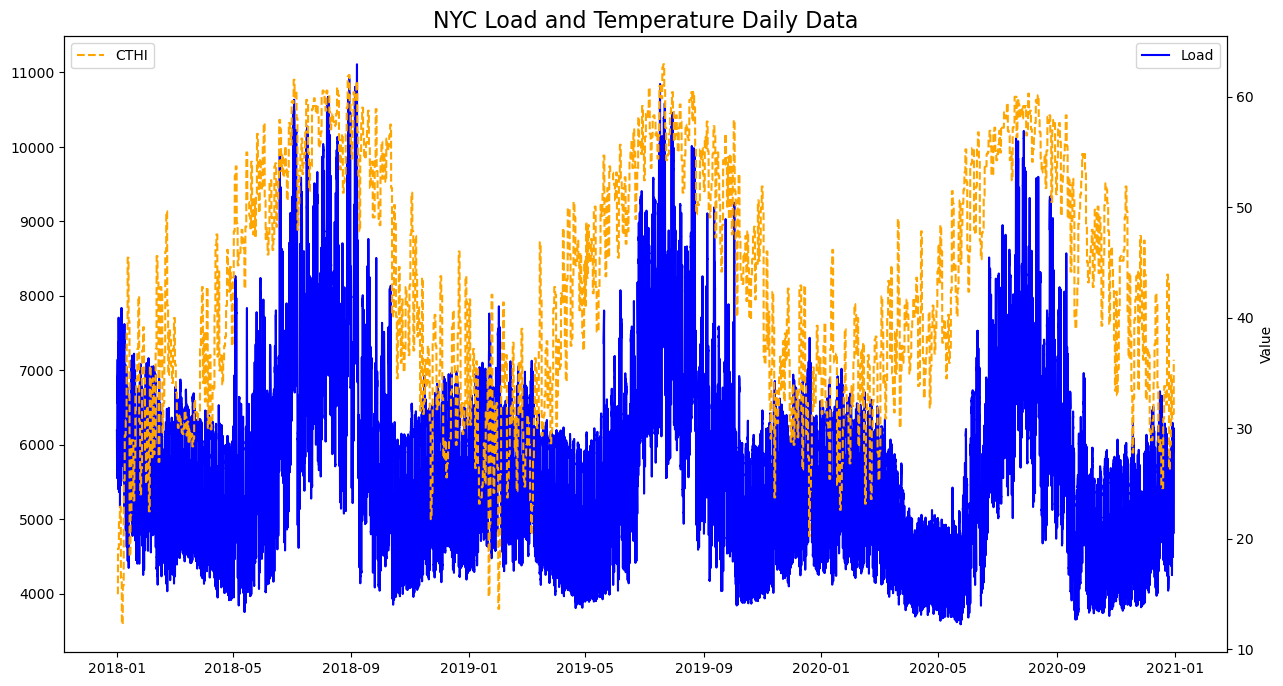

In [ ]:
# Zone J Plot - Load, CTHI, CDD and HDD avs
fig, ax1 = plt.subplots(figsize = (15, 8))
ax2 = ax1.twinx()

ax1.plot(data['Time Stamp'], data['Load'], label = 'Load', color = 'blue')
ax2.plot(data['Time Stamp'], data['CTHI'], label = 'CTHI', color = 'orange', linestyle = 'dashed')

# Set the axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('NYC Load and Temperature Daily Data', fontsize = 16)

# Add legend and show
ax1.legend(['Load'], loc = 'upper right')
ax2.legend(['CTHI'], loc = 'upper left')
plt.show();

### How about holidays?
The last dataset adjustment is with respect to holidays. The load usage during peak days (i.e. 8 AM - 12 AM during business days) is different than off-peak days (the hours between 8 AM to 12 AM in weekends and holidays). Thus, I make this adjustment to our dataset by creating Holiday or Off-Peak days accordingly. 

This will be later used as an exogenous variable in our forecasting exercise.

In [ ]:
# Holiday Calendar - NERC holidays
holiday_dict = {
    '2018-01-01': 1, '2018-05-28': 1, '2018-07-04': 1, '2018-09-03': 1 , '2018-11-22': 1, '2018-12-25': 1,
    '2019-01-01': 1, '2019-05-27': 1, '2019-07-04': 1, '2019-09-02': 1, '2019-11-28': 1, '2019-12-25': 1,
    '2020-01-01': 1, '2020-05-25': 1, '2020-07-05': 1, '2020-09-07': 1, '2020-11-26': 1, '2020-12-25': 1            
}

# Creating Holiday Column and mapping it
data['Holiday'] =  data['Time Stamp'].dt.strftime('%Y-%m-%d').map(holiday_dict)
data.loc[data['Holiday'].isna() == True, 'Holiday'] = 0

# Creating Off-Peak (OPK) Days 
data['OPK'] = data['Time Stamp'].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)
data.loc[data['OPK'] == 1, 'Holiday'] = 1

# Dropping OPK column
data = data.drop('OPK', axis = 1)

## Baseline modeling
I start with a baseline SARIMAX model. In order to run all processes, I reduce the sample size by 30%. After that, I create a Train-Test split so we can validate our models.

### Train-Test Split
On a Time Series approach, the train-test sets cannot be randomly assigned - since that will fail to capture time-varying dynamics. As such, I use the regular 75-25% split (train-test).


In [ ]:
# First I reduce the sample size, then I set up training and test data - with split sizes of 75-25
sample_size = (len(data) - 1) * 0.3
split_size = 0.25
train = data.iloc[:int(round(sample_size * (1 - split_size), 0))]
test = data.iloc[-int(round(sample_size * split_size, 0)):]

### Seasonal Decomposition
Since most likely the data has a seasonal component, I run a seasonal decomposition using 8,760 periods (which is the number of hours in an year). This step is necessary before checking stationarity.

Analyzing the decomposition plot, the series seem fairly stationary, we can see a growing trend toward the end of the series and the residuals seem to be hovering around zero - which might indicate normality. Then, the next step is checking whether the Load series are stationary after the seasonal decomposition.

In [ ]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(train[['Time Stamp', 'Load']].set_index('Time Stamp'), model = 'additive', period = 8760)

# Plot the decomposed components
decomposition.plot()
plt.show();




NameError: name 'seasonal_decompose' is not defined

### The ADF test - series stationarity
 Before setting up a baseline model, I check whether the Load series are stationary after the seasonal decomposition. 

To do so, I run an Augmented Dickey-Fuller test that has as its null series non-stationarity and as the alternative series are stationary. I use a p-value of 5% (0.05) as the test's significance level. Impressive as it is, we reject the null hypothesis - then we can infer the series are stationary. However, we need to account for the seasonality effect.

In [ ]:
# Running the Augmented Dickey-Fuller (ADF) test and checking the series stationarity
# We reject the null, thus the series are stationary

adftest = adfuller(decomposition.seasonal)
print('ADF test:')
print('======================')
print('p-value: ', round(adftest[1],4))
if adftest[1] >= 0.05:
        print('-Fail to reject H0.\n')
            
else:
        print('-H0 is rejected.\n')

ADF test:
p-value:  0.0
-H0 is rejected.



### Differencing to remove seasonality
In the next step, I apply the first difference to the load series to remove the seasonality. We can inspect that after the procedure the series become fairly stationary, hovering around 0. I also plot the rolling mean and standard deviation. By inspecting the rolling mean, we still see some seasonality patterns. Right below, I plot the autocorrelation and partial autocorrelation and it is clear there are several autoregressive and moving average components.

Since this is my baseline model, and it takes a long time to run a model with several lags, I will use a parcimonious approach with p and q being set to 1.

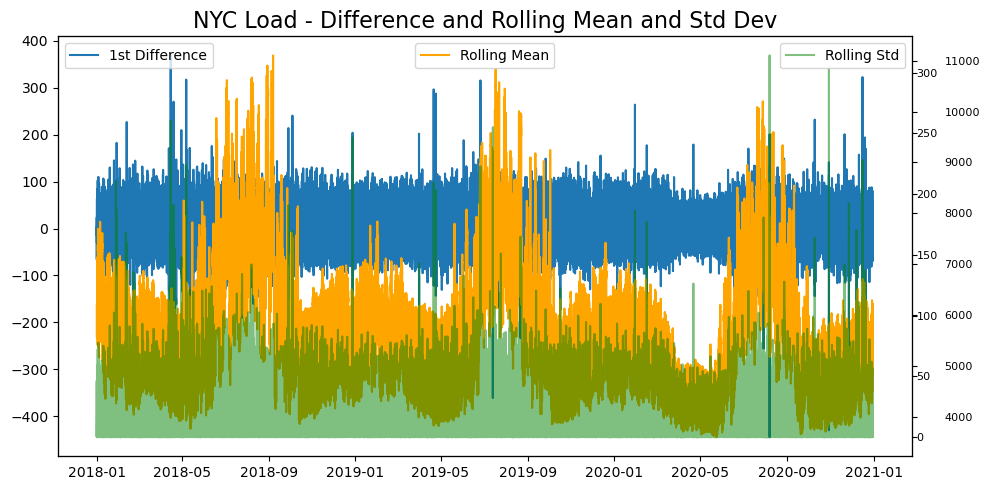

In [ ]:
# Creating the series to be plotted
data['Shift 1'] = data['Load'].diff(1).dropna()
data['Mean 1'] = data['Load'].rolling(window = 2, center = False).mean().dropna()
data['Std Dev 1'] = data['Load'].rolling(window = 2, center = False).std().dropna()

# Creating Plots
fig, ax1 = plt.subplots(figsize = (10, 5))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(data['Time Stamp'], data['Shift 1'], label = 'First Difference')
ax2.plot(data['Time Stamp'], data['Mean 1'], label = 'Rolling Mean', color = 'orange')
ax3.plot(data['Time Stamp'], data['Std Dev 1'], label = 'Rolling Std Dev', color = 'green', alpha = 0.5)

# Set the axis labels and title
plt.xlabel('Date')
plt.title('NYC Load - Difference and Rolling Mean and Std Dev', fontsize = 16)

# Add legend and show
ax1.legend(['1st Difference'], loc = 'upper left')
ax2.legend(['Rolling Mean'], loc = 'upper center')
ax3.legend(['Rolling Std'], loc = 'upper right')

# Padding
ax2.tick_params(axis = 'y', pad = 20, labelsize = 8)
ax3.tick_params(axis = 'y', pad = 0, labelsize = 8)
plt.tight_layout()
plt.show();




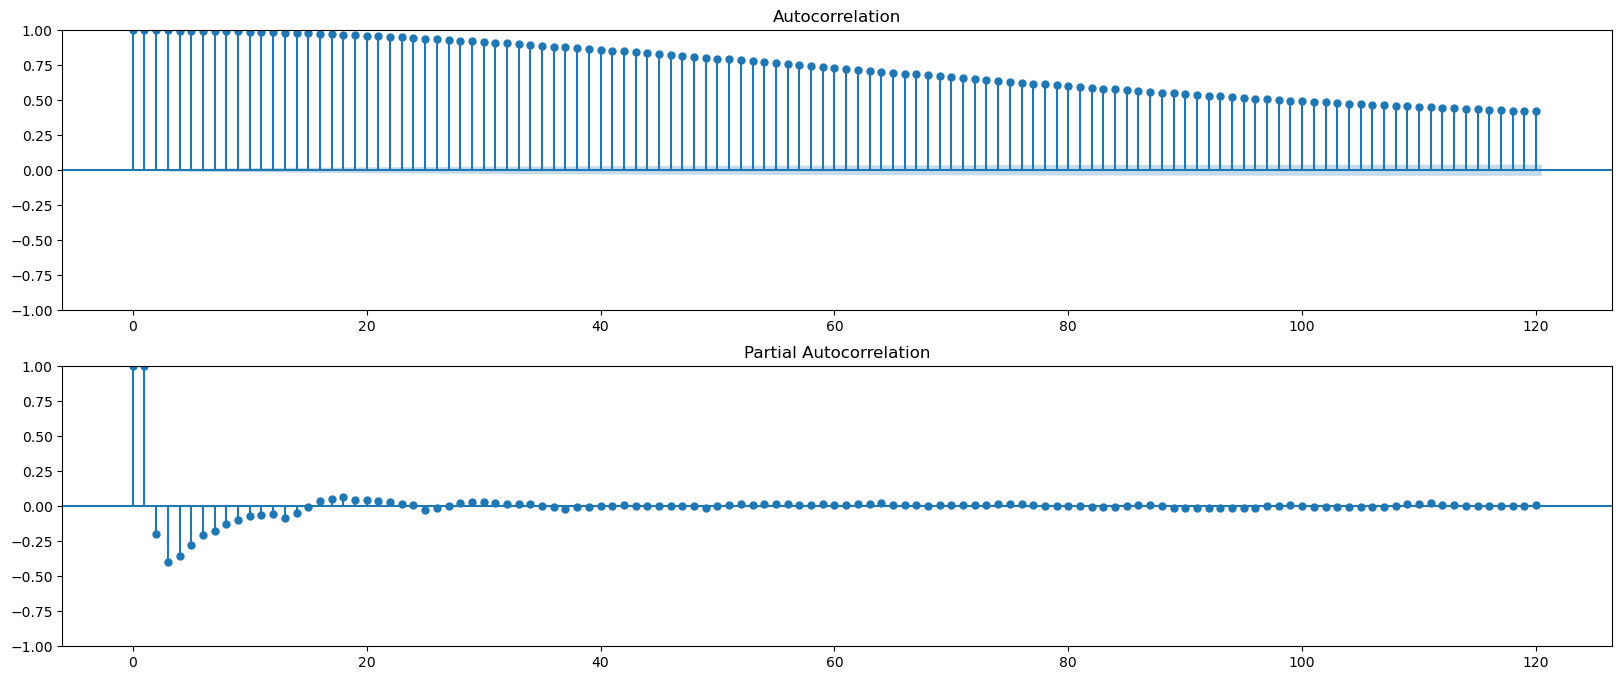

In [ ]:
# Running the partial autocorrelation and partial autocorrelation plots
func_plot(data['Load'])

### SARIMAX model
The first SARIMAX model is run using a naive approach with just one autoregressive (AR) and one Moving Average (MA) component. Since using 8,760 periods (i.e. the number of hours in a given year that is not a leap year) are computationally intensive, I limit those to 24 periods.

But before running the model, I make some adjustments to the database so we can account for the exogenous variables as well. The model takes around 20 min to run using a Macbook Air (M1 Chip). Even though far from being the most rigorous exercise, it provides good results. 

From a high level view, we can check that residuals look very like white noise. At the same time, the correlogram doesn't look like a normal distribution. We can reject the null from the Jarque-Bera statistic at the 1% critical level. This can be easily inspected since its kurtosis is far from being 3, even though the skewness is close to 0. Furthermore, the Ljung-Box statistics provides evidence of autocorrelation - which can be a byproduct of the number of lags.

Lastly, the QQ plot also show some deviations from normality, specially at the extreme lower and upper quantiles. The Mean Absolute Error (MAPE) is extremely low and the fit seems to be visually adherent using a 24 hour (next-day) period using training data.


In [ ]:
# Setting up endogenous and exogenous databases with train and test data

# Starting with the exogenous
train_exo, test_exo = train[['Time Stamp', 'CTHI', 'CDD', 'HDD', 'Holiday']].set_index('Time Stamp'), \
test[['Time Stamp', 'CTHI', 'CDD', 'HDD', 'Holiday']].set_index('Time Stamp')

# Setting up then Train and Test
train, test = train[['Time Stamp', 'Load']].set_index('Time Stamp'), test[['Time Stamp', 'Load']].set_index('Time Stamp')

# SARIMAX baseline model
mape_calc(train, exog = train_exo, pdq = (1, 1, 1), pdqs = (1, 1, 1, 24), train_test = 'train', window = 24)

In [ ]:
# SARIMAX forecasting
forecast_ci(test, exog = test_exo, pdq = (1, 1, 1), pdqs = (1, 1, 1, 24))

/Users/orlandovilar/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/orlandovilar/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/orlandovilar/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/orlandovilar/miniconda3/envs/tf/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.75328D+00    |proj g|=  2.29349D-01

At iterate    5    f=  4.66382D+00    |proj g|=  8.45373D-02

At iterate   10    f=  4.60014D+00    |proj g|=  3.25470D-02

At iterate   15    f=  4.50294D+00    |proj g|=  1.21626D-02

At iterate   20    f=  4.48630D+00    |proj g|=  1.25705D-02

At iterate   25    f=  4.48607D+00    |proj g|=  2.82818D-03

At iterate   30    f=  4.48587D+00    |proj g|=  1.19585D-03


KeyboardInterrupt: 

## LSTM
With the LSTM model, I am going to use the Holiday dataset (i.e. the dfx DataFrame)

In [ ]:
# Setting up the train, test and holdout set
train_set = data.iloc[: int(round(0.5 * len(data), 0))]
test_set =  data.iloc[int(round(0.5 * len(data), 0)) : int(round(0.75 * len(data), 0))]
houldout_set = data.iloc[int(round(0.75 * len(data), 0)) : ]

# Converting data to LTSM's format
features = ['CTHI','Holiday']
target = 'Load'
features_target = features.copy()
features_target.append(target)

# Now, Setting up for keras - Step #1
train_data_keras = train_set[features_target]
test_data_keras = test_set[features_target]

# Running StandardScaler, fitting and transforming
scaler = StandardScaler()
train_data_keras_s = scaler.fit_transform(train_data_keras.values) 
test_data_keras_s = scaler.transform(test_data_keras.values)

# Setting up for keras -  Step #2
X_train_keras = (
    train_data_keras_s[:,:-1].
    reshape(train_data_keras_s.shape[0],1,len(features))
)
y_train_keras = train_data_keras_s[:,-1]

X_test_keras = (
    test_data_keras_s[:,:-1].
    reshape(test_data_keras_s.shape[0],1,len(features))
)
y_test_keras = test_data_keras_s[:,-1]

# Setting up the neural network model
tf.random.set_seed(42)
adam = Adam(lr = 0.005)


In [ ]:

# Creating and compiling the NN
model = Sequential()
model.add(LSTM(256, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = adam)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint('./single_lstm/checkpoint',save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor =  monitor_param, factor = 0.1, patience = 5, verbose = 0, mode = mode)

# Fitting the model
history = model.fit(X_train_keras, y_train_keras, epochs = 8, batch_size = 24, validation_data = (X_test_keras, y_test_keras),
callbacks = [early_stopping, checkpoint_save, reduce_lr_loss])


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/400


2023-04-22 19:30:06.626395: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1111/1111 [==============================] - 12s 10ms/step - loss: 0.5938 - val_loss: 0.5536 - lr: 0.0010
Epoch 2/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5581 - val_loss: 0.5488 - lr: 0.0010
Epoch 3/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5538 - val_loss: 0.5518 - lr: 0.0010
Epoch 4/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5527 - val_loss: 0.5537 - lr: 0.0010
Epoch 5/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5521 - val_loss: 0.5490 - lr: 0.0010
Epoch 6/400
1111/1111 [==============================] - 11s 9ms/step - loss: 0.5516 - val_loss: 0.5509 - lr: 0.0010
Epoch 7/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5517 - val_loss: 0.5505 - lr: 0.0010
Epoch 8/400
1111/1111 [==============================] - 11s 10ms/step - loss: 0.5510 - val_loss: 0.5499 - lr: 1.0000e-04
Epoch 9/400
1111/1111 [==============================] - 11s 10ms

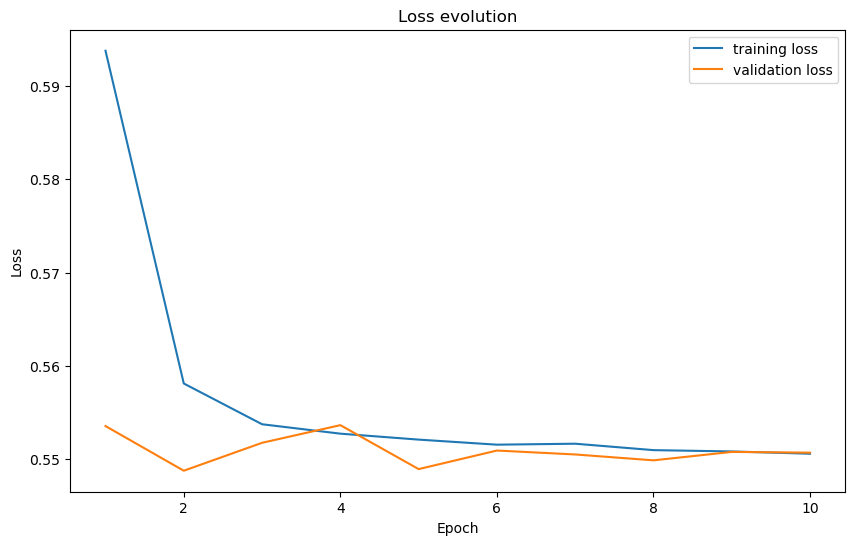

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["loss"],
    label="training loss",
)
ax.plot(
    range(1, len(history.history["loss"]) + 1),
    history.history["val_loss"],
    label="validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

2500/2500 [==============================] - 7s 3ms/step


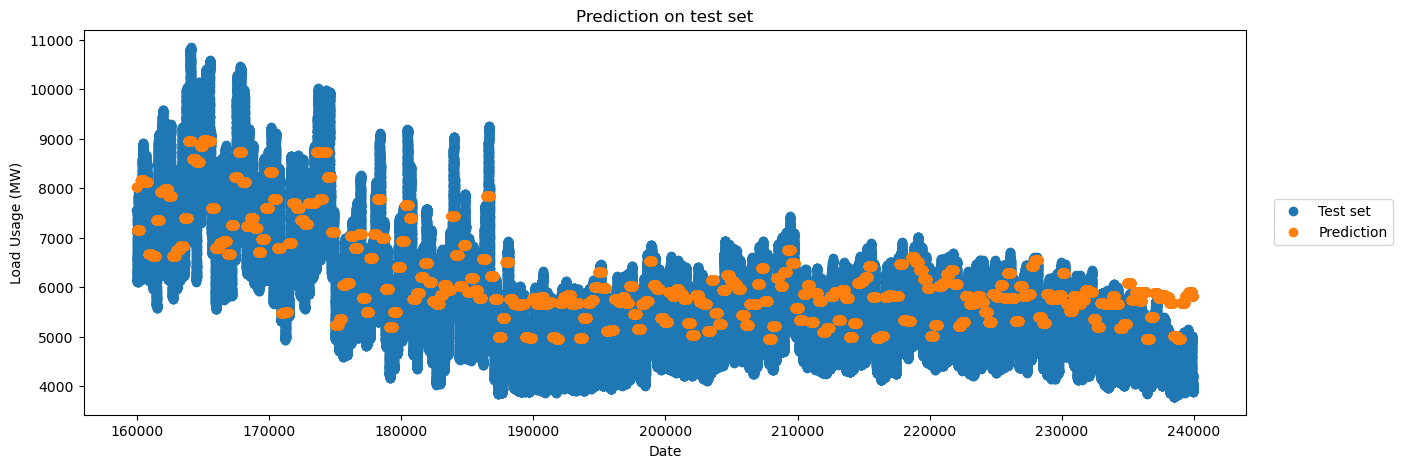

In [ ]:
# Using the test set for prediction
pred_lstm = model.predict(X_test_keras)

# Inverse the transform prediction
results_lstm = test_data_keras_s
results_lstm[:,-1] = pred_lstm.reshape(pred_lstm.shape[0])
results_lstm = scaler.inverse_transform(results_lstm)

# Storing inverse transformed
df_results = pd.DataFrame(results_lstm, columns = test_data_keras.columns, index = test_data_keras.index)

# Plotting it
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(test_data_keras.index, test_data_keras['Load'], 'o', label = 'Test set')
ax.plot(test_data_keras.index, df_results['Load'], "o", label = 'Prediction')

ax.legend(loc = "center", bbox_to_anchor = (1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Load Usage (MW)")
ax.set_xlabel("Date");

## Deep LSTM

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape = (X_train_keras.shape[1], X_train_keras.shape[2]), return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences = True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))

model.add(Dense(1))
model.compile(loss = 'mae', optimizer = adam)

# Callbacks
monitor_param = 'val_loss'
mode = 'min'
early_stopping = EarlyStopping(monitor = monitor_param, patience = 8, verbose = 0, mode = mode)
checkpoint_save = ModelCheckpoint(
    './deep_lstm/checkpoint', save_weights_only = True, monitor = monitor_param, mode = mode)
reduce_lr_loss = ReduceLROnPlateau(monitor=monitor_param, factor=0.1, patience=5, verbose=0, mode=mode)

# Fit model
history_deep_lstm = model.fit(X_train_keras, y_train_keras, epochs = 20, batch_size = 30, 
                              validation_data = (X_test_keras, y_test_keras), 
                              callbacks = [early_stopping, checkpoint_save, reduce_lr_loss])


Epoch 1/20
5333/5333 [==============================] - 100s 18ms/step - loss: 0.5682 - val_loss: 0.5911 - lr: 0.0050
Epoch 2/20
5333/5333 [==============================] - 98s 18ms/step - loss: 0.5593 - val_loss: 0.5809 - lr: 0.0050
Epoch 3/20
5333/5333 [==============================] - 97s 18ms/step - loss: 0.5570 - val_loss: 0.5882 - lr: 0.0050
Epoch 4/20
5333/5333 [==============================] - 93s 17ms/step - loss: 0.5557 - val_loss: 0.6118 - lr: 0.0050
Epoch 5/20
5333/5333 [==============================] - 92s 17ms/step - loss: 0.5551 - val_loss: 0.6195 - lr: 0.0050
Epoch 6/20
5330/5333 [============================>.] - ETA: 0s - loss: 0.5550

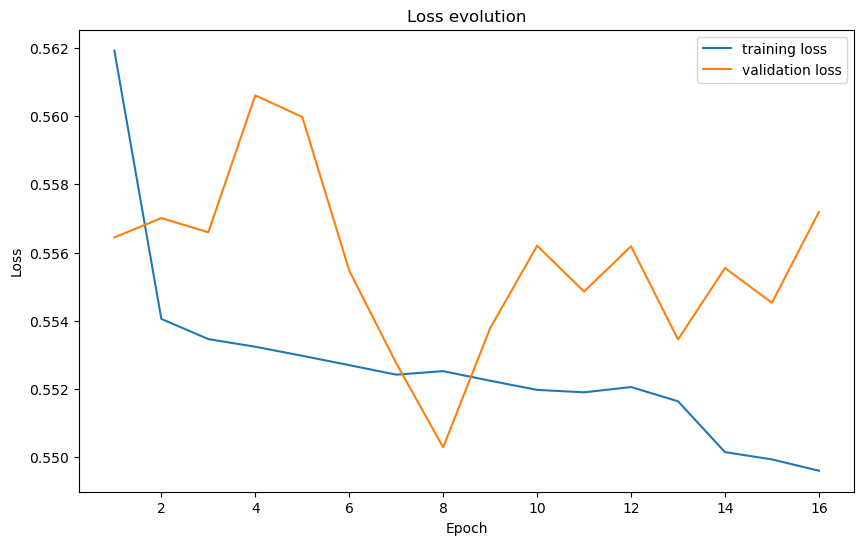

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["loss"],
    label = "training loss",
)
ax.plot(
    range(1, len(history_deep_lstm.history["loss"]) + 1),
    history_deep_lstm.history["val_loss"],
    label = "validation loss",
)

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss evolution")
ax.legend(loc="best");

In [ ]:
# Prediction on test set
pred_deep_lstm = model.predict(X_test_keras)

# Inverse transform the prediction
# Since scaler was fit using all the data (9 features + outcome variable)
# we need to store the prediction in the a copy of the original data
results_deep_lstm = test_data_keras_s
results_deep_lstm[:,-1] = pred_deep_lstm.reshape(pred_deep_lstm.shape[0])
results_deep_lstm = scaler.inverse_transform(results_deep_lstm)

# Store inverse transformed preductons in the result dataframe
# Storing inverse transformed
df_results = pd.DataFrame(results_deep_lstm, columns = test_data_keras.columns, index = test_data_keras.index)
# df_results['pred_deep_lstm'] = results_deep_lstm[:,-1]

2500/2500 [==============================] - 12s 5ms/step


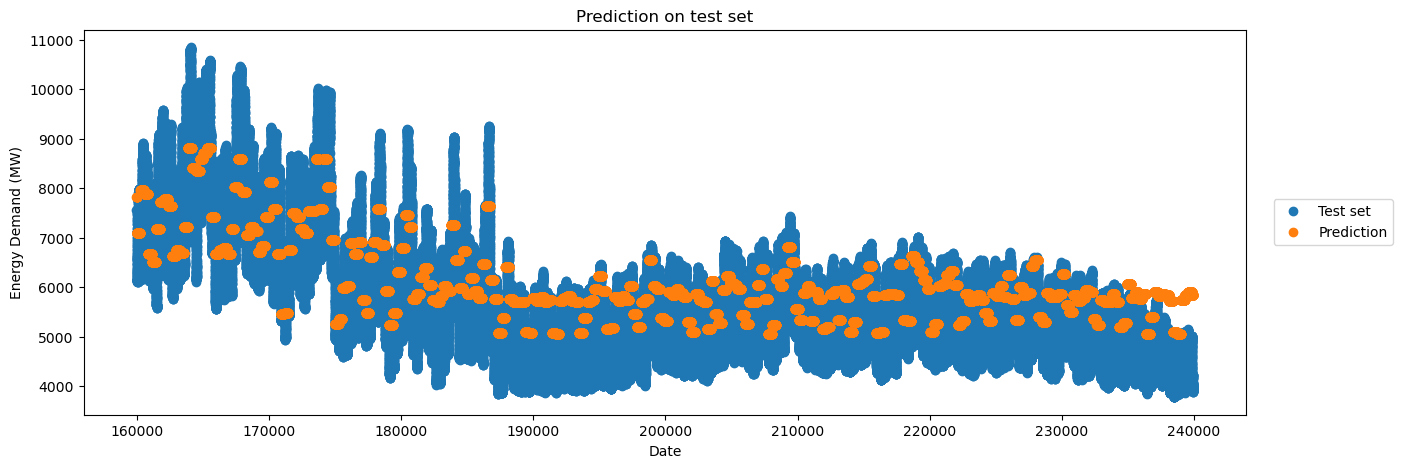

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(test_data_keras.index, test_data_keras['Load'], "o", label = "Test set")
ax.plot(test_data_keras.index, df_results["Load"], "o", label = "Prediction")

ax.legend(loc="center", bbox_to_anchor=(1.075, 0.5))

ax.set_title("Prediction on test set")
ax.set_ylabel("Energy Demand (MW)")
ax.set_xlabel("Date");

In [ ]:
mape(test_data_keras["Load"], df_results["Load"])

12.40271738263629